# Project 2: Topic Classification

In this project, you'll work with text data from newsgroup postings on a variety of topics. You'll train classifiers to distinguish between the topics based on the text of the posts. Whereas with digit classification, the input is relatively dense: a 28x28 matrix of pixels, many of which are non-zero, here we'll represent each document with a "bag-of-words" model. As you'll see, this makes the feature representation quite sparse -- only a few words of the total vocabulary are active in any given document. The bag-of-words assumption here is that the label depends only on the words; their order is not important.

The SK-learn documentation on feature extraction will prove useful:
http://scikit-learn.org/stable/modules/feature_extraction.html

Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please prepare your own write-up and write your own code.

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

/Users/marceloqueiroz/anaconda3/envs/py27/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/marceloqueiroz/anaconda3/envs/py27/lib/python2.7/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Load the data, stripping out metadata so that we learn classifiers that only use textual features. By default, newsgroups data is split into train and test sets. We further split the test so we have a dev set. Note that we specify 4 categories to use for this project. If you remove the categories argument from the fetch function, you'll get all 20 categories.

In [2]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test',
                                     remove=('headers', 'footers', 'quotes'),
                                     categories=categories)

num_test = len(newsgroups_test.target)
test_data, test_labels = newsgroups_test.data[num_test/2:], newsgroups_test.target[num_test/2:]
dev_data, dev_labels = newsgroups_test.data[:num_test/2], newsgroups_test.target[:num_test/2]
train_data, train_labels = newsgroups_train.data, newsgroups_train.target

print 'training label shape:', train_labels.shape
print 'test label shape:', test_labels.shape
print 'dev label shape:', dev_labels.shape
print 'labels names:', newsgroups_train.target_names

training label shape: (2034,)
test label shape: (677,)
dev label shape: (676,)
labels names: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


(1) For each of the first 5 training examples, print the text of the message along with the label.

[2 pts]

In [43]:
def P1(num_examples=5):
    '''
    P1(num_examples = 5)
    
    Parameters:
    num_examples: integer with number of messages to print.
    
    Prints the first 'num_examples' labels and messages from the training set. Also returns a dictionary where the
    key is the message and the value is the label code associated with it.
    '''
    print 'First {0} examples of the training set:\n'.format(num_examples)
    output_array = {}

    for i in range(num_examples):
        print '=> {0}) Label: {1}, Message: \n{2}\n'.format(i+1, newsgroups_train.target_names[train_labels[i]],
                                                       train_data[i])
        output_array[train_data[i]] = train_labels[i]

    return output_array

P1(5)


First 5 examples of the training set:

=> 1) Label: comp.graphics, Message: 
Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych

=> 2) Label: talk.religion.misc, Message: 


Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional mania. Jim
Jones, circa 1993.


Nope - fruitcakes like Koresh 

{u'\n\nSeems to be, barring evidence to the contrary, that Koresh was simply\nanother deranged fanatic who thought it neccessary to take a whole bunch of\nfolks with him, children and all, to satisfy his delusional mania. Jim\nJones, circa 1993.\n\n\nNope - fruitcakes like Koresh have been demonstrating such evil corruption\nfor centuries.': 3,
 u"\n >In article <1993Apr19.020359.26996@sq.sq.com>, msb@sq.sq.com (Mark Brader) \n\nMB>                                                             So the\nMB> 1970 figure seems unlikely to actually be anything but a perijove.\n\nJG>Sorry, _perijoves_...I'm not used to talking this language.\n\nCouldn't we just say periapsis or apoapsis?\n\n ": 2,
 u'AW&ST  had a brief blurb on a Manned Lunar Exploration confernce\nMay 7th  at Crystal City Virginia, under the auspices of AIAA.\n\nDoes anyone know more about this?  How much, to attend????\n\nAnyone want to go?': 2,
 u"Hi,\n\nI've noticed that if you only save a model (with all your mapping plan

(2) Use CountVectorizer to turn the raw training text into feature vectors. You should use the fit_transform function, which makes 2 passes through the data: first it computes the vocabulary ("fit"), second it converts the raw text into feature vectors using the vocabulary ("transform").

The vectorizer has a lot of options. To get familiar with some of them, write code to answer these questions:

a. The output of the transform (also of fit_transform) is a sparse matrix: http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html. What is the size of the vocabulary? What is the average number of non-zero features per example? What fraction of the entries in the matrix are non-zero? Hint: use "nnz" and "shape" attributes.

b. What are the 0th and last feature strings (in alphabetical order)? Hint: use the vectorizer's get_feature_names function.

c. Specify your own vocabulary with 4 words: ["atheism", "graphics", "space", "religion"]. Confirm the training vectors are appropriately shaped. Now what's the average number of non-zero features per example?

d. Instead of extracting unigram word features, use "analyzer" and "ngram_range" to extract bigram and trigram character features. What size vocabulary does this yield?

e. Use the "min_df" argument to prune words that appear in fewer than 10 documents. What size vocabulary does this yield?

f. Using the standard CountVectorizer, what fraction of the words in the dev data are missing from the vocabulary? Hint: build a vocabulary for both train and dev and look at the size of the difference.

[6 pts]

In [76]:
def P2(data):
    ### STUDENT START ###
    vectorizer = CountVectorizer()
    vector_data = vectorizer.fit_transform(data)
    
    return [vector_data, vectorizer]

    ### STUDENT END ###
question2 = P2(train_data)


In [73]:
print '=> a. Size of Vocabulary: {0} words\n Average number of non-zero features per example: {1} words\n fraction of the entries in the matrix are non-zero: {2:.2f} %'.format(question2[0].shape[1],question2[0].nnz/question2[0].shape[0],float(question2[0].nnz)*100/(question2[0].shape[1]*question2[0].shape[0]))
print '=> b. First feature: "{0}". Last Feature: "{1}".'.format(question2[1].get_feature_names()[0], question2[1].get_feature_names()[-1])

=> a. Size of Vocabulary: 26879 words
 Average number of non-zero features per example: 96 words
 fraction of the entries in the matrix are non-zero: 0.36 %
=> b. First feature: "00". Last Feature: "zyxel".


In [83]:
vocab =  ["atheism", "graphics", "space", "religion"]
new_vocab_data = question2[1].fit(vocab)
question2c = new_vocab_data.transform(train_data)

print '=> c. Vector shape: {0}, as expected.\n Average number of non-zero features per example: {1:.2f}'.format(question2c.shape,float(question2c.nnz)/question2c.shape[0])

=> c. Vector shape: (2034, 4), as expected.
 Average number of non-zero features per example: 0.27


In [94]:
def P2D(data):
    vectorizer = CountVectorizer(ngram_range=(1, 3), analyzer='word')
    vector_data = vectorizer.fit_transform(data)
    return [vector_data, vectorizer]

question2d = P2D(train_data)


In [97]:
print '=> d. Size of Vocabulary with bi and tri-grams: {0} grams'.format(question2d[0].shape[1])

=> d. Size of Vocabulary with bi and tri-grams: 537462 grams


In [98]:
def P2E(data):
    vectorizer = CountVectorizer(ngram_range=(1, 3), analyzer='word', min_df=10)
    vector_data = vectorizer.fit_transform(data)
    return [vector_data, vectorizer]

question2e = P2E(train_data)
print '=> e. Size of Vocabulary with bi and tri-grams pruned on 10%: {0} grams'.format(question2e[0].shape[1])

=> e. Size of Vocabulary with bi and tri-grams pruned on 10%: 6445 grams


In [120]:
def P2F(train, dev):
    vectorizer = CountVectorizer()
    vector_train = vectorizer.fit_transform(train)
    train_labels = vectorizer.get_feature_names()
    
    vector_dev = vectorizer.fit_transform(dev)
    dev_labels = vectorizer.get_feature_names()
   
    missing_labels = np.setdiff1d(dev_labels, train_labels, assume_unique=True)
    print 'Ratio of words in dev set that are not in train vocabulary: {0:.2f} %'.format(float(missing_labels.size)/vector_train.shape[1]*100)
    
    return(missing_labels)

P2F(train_data, dev_data)

Ratio of words in dev set that are not in train vocabulary: 14.98 %


array([u'00043819', u'00044808', u'00044939', ..., u'zubrin', u'zuni',
       u'zyda'], dtype='<U80')

(3) Use the default CountVectorizer options and report the f1 score (use metrics.f1_score) for a k nearest neighbors classifier; find the optimal value for k. Also fit a Multinomial Naive Bayes model and find the optimal value for alpha. Finally, fit a logistic regression model and find the optimal value for the regularization strength C using l2 regularization. A few questions:

a. Why doesn't nearest neighbors work well for this problem?

b. Any ideas why logistic regression doesn't work as well as Naive Bayes?

c. Logistic regression estimates a weight vector for each class, which you can access with the coef\_ attribute. Output the sum of the squared weight values for each class for each setting of the C parameter. Briefly explain the relationship between the sum and the value of C.

[4 pts]

In [425]:
def P3_KNN(train_data, train_targets, test_data, test_targets, values):
    
    #setting the dictionary and the vector of features for each dataset:
    vectorizer = CountVectorizer()
    vector_train = vectorizer.fit_transform(train_data)
    vector_test = vectorizer.transform(test_data)
    #print vector_train.shape, train_targets.shape

    #K-Nearest neighbors fit
    modKNN = GridSearchCV(KNeighborsClassifier(), param_grid=values[0])
    modKNN = modKNN.fit(vector_train, train_targets)
    
    predictedKNN = modKNN.predict(vector_test)
    
    f1_resultKNN = metrics.f1_score(test_targets, predictedKNN, average='macro') 
        
    print 'K-Nearest Neighbors model:\n Best k-value: {0}\n Best Accuracy: {1:.2f} %\n F1-Score: {2:.2f}\n'.format(modKNN.best_params_['n_neighbors'], modKNN.best_score_, f1_resultKNN)
    
    #Multinomial Naive Bayes algorithm fit
    modNB = GridSearchCV(MultinomialNB(), param_grid=values[1])
    modNB = modNB.fit(vector_train, train_targets)
    
    predictedNB = modNB.predict(vector_test)
    
    f1_resultNB = metrics.f1_score(test_targets, predictedNB, average='macro') 
    
    print 'Mutinomial Naive Bayes model:\n Best alpha: {0}\n Best Accuracy: {1:.2f} %\n F1-Score: {2:.2f}\n'.format(modNB.best_params_['alpha'], modNB.best_score_, f1_resultNB)
    
    #Logistic Regression Algorithm fit
    modLR = GridSearchCV(LogisticRegression(), param_grid=values[2])
    modLR = modLR.fit(vector_train, train_targets)
    
    predictedLR = modLR.predict(vector_test)
    
    f1_resultLR = metrics.f1_score(test_targets, predictedLR, average='macro')

    print 'Logistic Regression model:\n Best C: {0}\n Best Accuracy: {1:.2f} %\n F1-Score: {2:.2f}\n'.format(modLR.best_params_['C'], modLR.best_score_, f1_resultLR)
    
    for c in values[2]['C']:
        modLR2 = LogisticRegression(C=c)
        modLR2 = modLR2.fit(vector_train, train_targets)
        
        print'For C={0}, the sum of the squared weight values is:{1}'.format(c,np.square(modLR2.coef_).sum(axis=1))
    
values = [{'n_neighbors':[i for i in range(1,100,2)]}, 
          {'alpha': [0.0, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]},
          {'C':[10**k for k in range(-5,5)]}]
P3_KNN(train_data, train_labels, dev_data, dev_labels, values)

K-Nearest Neighbors model:
 Best k-value: 95
 Best Accuracy: 0.44 %
 F1-Score: 0.44

Mutinomial Naive Bayes model:
 Best alpha: 0.01
 Best Accuracy: 0.83 %
 F1-Score: 0.76

Logistic Regression model:
 Best C: 0.1
 Best Accuracy: 0.77 %
 F1-Score: 0.68

For C=1e-05, the sum of the squared weight values is:[0.00031351 0.00061013 0.00038483 0.00034146]
For C=0.0001, the sum of the squared weight values is:[0.00770175 0.0119412  0.00943508 0.00910284]
For C=0.001, the sum of the squared weight values is:[0.16509345 0.20095275 0.18067094 0.18724278]
For C=0.01, the sum of the squared weight values is:[2.54139589 2.93970937 2.86246884 2.25002868]
For C=0.1, the sum of the squared weight values is:[27.13465361 24.65876281 27.45839548 23.0209231 ]
For C=1, the sum of the squared weight values is:[166.9976657  130.9242447  158.02131132 145.71535688]
For C=10, the sum of the squared weight values is:[586.60932474 449.24063855 540.63301964 530.88094065]
For C=100, the sum of the squared weight va

**ANSWERS:**
**a.** The K-Nearest Neighbors algorithm doesn't work well because our sparse matrix. This algorithm is based on finding the distances between points in the hyperspace of solutions and associate them with near training examples. With our hyperspace containing close to 26 thousand works and each documents containing 96 words in average, the distance calculation becomes similar to all examples. This explains the best performance with a high number of K and the low accuracy of the model.

**b.** Both methods calculate the likelihood of a given set of words belongs to an specific label or P(Y belongs to topic | X) = [0,1]. However on Logistic regression we have that changing the coeeficients means adjusting one specific curve while on Naive Bayes we are working with each word on the sentence. Since our model uses the bag-of-words assumption where there is no relationship between words, the use of the sigmoid function to model the probability of belonging to a class in Logistic regression seems to be a poor model for parameter prediction.

**c.** We notice that the higher the C vakue, the bigger the sum of the squared weight and also the bigger the differences between the weights. This way, we see that increasing the regularization of our model we are making our work area smaller, avoiding overfitting the model on the training set. We can go to such a small value for C that we actually start underfitting the model, making it ignore real details  and being too generalistic.

(4) Train a logistic regression model. Find the 5 features with the largest weights for each label -- 20 features in total. Create a table with 20 rows and 4 columns that shows the weight for each of these features for each of the labels. Create the table again with bigram features. Any surprising features in this table?

[5 pts]

In [286]:
def P4(train_data, train_targets, test_data, test_targets, ngram_range = (1,1)):
    #setting the dictionary and the vector of features for each dataset:
    vectorizer = CountVectorizer(ngram_range = ngram_range)
    vector_train = vectorizer.fit_transform(train_data)
    vector_test = vectorizer.transform(test_data)
    
    #fitting the model
    modLR3 = LogisticRegression(C=0.01)
    modLR3 = modLR3.fit(vector_train, train_targets)
    
    predictedLR3 = modLR3.predict(vector_test)
    
    f1_resultLR = metrics.f1_score(test_targets, predictedLR3, average='macro')
    print 'F1-Score: {:.2f}'.format(f1_resultLR)
    
    #rows for the table:
    rows = np.argsort(modLR3.coef_, axis = 1)[:,-5:].flatten()
    row_labels = []
    
    for i in rows:
        row_labels.append(vectorizer.get_feature_names()[i])

    #columns for the table:
    columns = ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']

    table = np.empty((20,4))

    for row in range(len(rows)):
        for col in range(len(columns)):
            table[row][col] = np.round(modLR3.coef_[col][rows[row]],2)

    ax = plt.subplot(111, frame_on=False) 

    # print a table using pyplot. Hiding axis because the plot that is integrated is not needed.
    ax.xaxis.set_visible(False) 
    ax.yaxis.set_visible(False)
    table = ax.table(cellText=table,
                          rowLabels=row_labels,
                          colLabels=columns,
                          loc='top')
    table.set_fontsize(14)
    table.scale(1.5, 1.5)

Table for unigram model:
F1-Score: 0.64


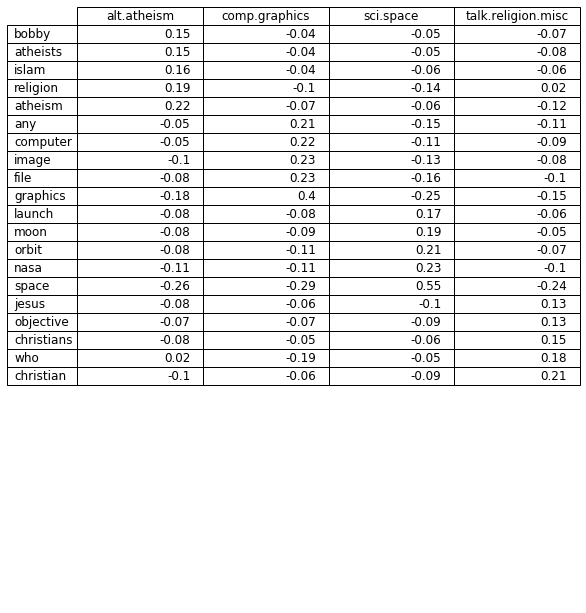

In [287]:
print 'Table for unigram model:'
P4(train_data, train_labels, dev_data, dev_labels)

Table for bigrams model:
F1-Score: 0.51


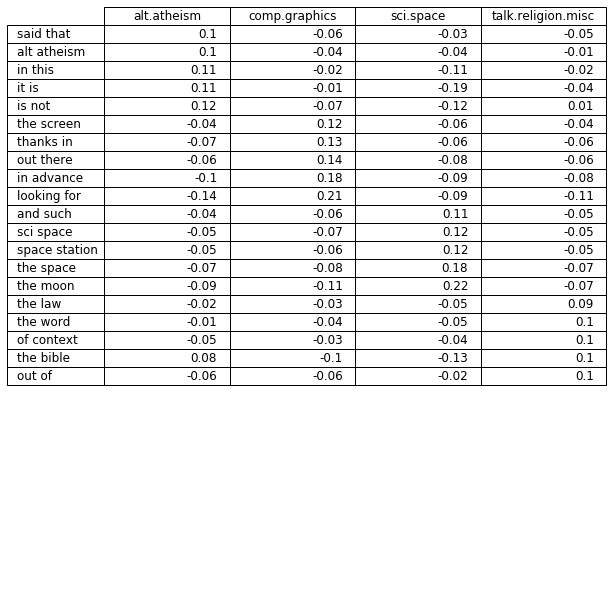

In [288]:
print 'Table for bigrams model:'
P4(train_data, train_labels, dev_data, dev_labels, ngram_range = (2,2))

Table for uni and bigram model:
F1-Score: 0.65


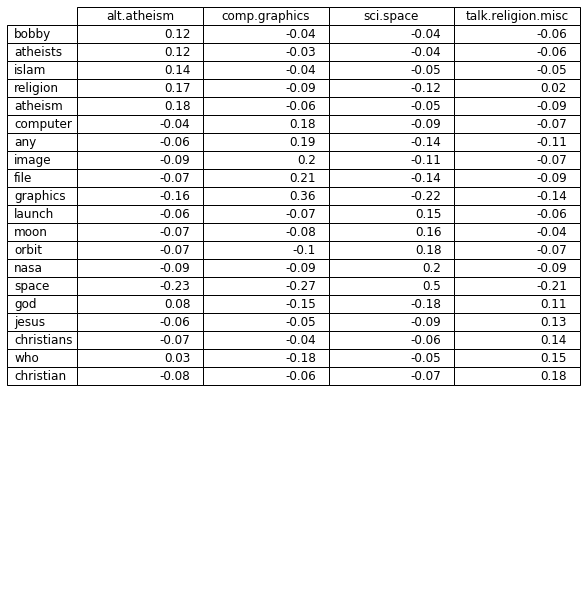

In [289]:
print 'Table for uni and bigram model:'
P4(train_data, train_labels, dev_data, dev_labels, ngram_range = (1,2))

**ANSWER:** When using the unigram model we notice that the words are related to the topic, with the results being intuitive. However when using only the bigrams are not so clearly related, with some like "said that" and "it is" being associated with some labels (although some liek "the moon" and "the bible" are self explanatory). To check the efficacy of that technique I added the F1 score to the output and as expected the bigrams only model is less effective. I also tested a model containing both uni and bigrams and the best features are exactly the ones we had before, with only unigrams, although with lower weights. It is interesting to note that using bigrams proved not always good, once it takes substantial more processing power to deliver the same set of words with 1% improve in F1 score.

(5) Try to improve the logistic regression classifier by passing a custom preprocessor to CountVectorizer. The preprocessing function runs on the raw text, before it is split into words by the tokenizer. Your preprocessor should try to normalize the input in various ways to improve generalization. For example, try lowercasing everything, replacing sequences of numbers with a single token, removing various other non-letter characters, and shortening long words. If you're not already familiar with regular expressions for manipulating strings, see https://docs.python.org/2/library/re.html, and re.sub() in particular. With your new preprocessor, how much did you reduce the size of the dictionary?

For reference, I was able to improve dev F1 by 2 points.

[4 pts]

In [406]:
def empty_preprocessor(s):
    return s

def better_preprocessor(s):
    s = s.lower() #all text to lowercase
    s = re.sub(r'[_%#:+]', r'', s) #Remove all punctuations
    s = re.sub(r'[0-9]{5,}',r'*NUMBER*', s) #replacing long numbers with something unique.
    s = re.sub(r'\w(.)\1+',r'', s) #removing text with more than 1 repeated charachter
    s = re.sub(r's\b|sms\b|sts\b|sm\b|st\b|ed\b',r'',s) #removing plurals, "sms", "ed", and "sts" at the end of words (based on our previous test.)
    return s

def P5(train_data, train_targets, test_data, test_targets, processor):
    #run the pre-processor for test
    new_train_data = []
    new_test_data = []
    for i in train_data:
        new_train_data.append(processor(i))
    for k in test_data:
        new_test_data.append(processor(k))
    
    vectorizer = CountVectorizer()
    vector_train = vectorizer.fit_transform(new_train_data)
    vector_test = vectorizer.transform(new_test_data)
    
    modLR4 = LogisticRegression()
    modLR4 = modLR4.fit(vector_train, train_targets)
    
    predictedLR4 = modLR4.predict(vector_test)
    
    f1_resultLR4 = metrics.f1_score(test_targets, predictedLR4, average='macro')
    print 'Used processor: {0}.\n F1-Score {1}\n Dictionary Size: {2}'.format(processor.__name__, f1_resultLR4, len(vectorizer.get_feature_names()))
    
    return len(vectorizer.get_feature_names())


In [407]:
size_nopre = P5(train_data, train_labels, dev_data, dev_labels, empty_preprocessor)
size_pre = P5(train_data, train_labels, dev_data, dev_labels, better_preprocessor)

reduction = size_nopre - size_pre

print 'Vocabulary reduction = {0}, or {1:.2f} %'.format(reduction, float(reduction)/size_nopre * 100)

Used processor: empty_preprocessor.
 F1-Score 0.681318340101
 Dictionary Size: 26879
Used processor: better_preprocessor.
 F1-Score 0.702318797081
 Dictionary Size: 22272
Vocabulary reduction = 4607, or 17.14 %


(6) The idea of regularization is to avoid learning very large weights (which are likely to fit the training data, but not generalize well) by adding a penalty to the total size of the learned weights. That is, logistic regression seeks the set of weights that minimizes errors in the training data AND has a small size. The default regularization, L2, computes this size as the sum of the squared weights (see P3, above). L1 regularization computes this size as the sum of the absolute values of the weights. The result is that whereas L2 regularization makes all the weights relatively small, L1 regularization drives lots of the weights to 0, effectively removing unimportant features.

Train a logistic regression model using a "l1" penalty. Output the number of learned weights that are not equal to zero. How does this compare to the number of non-zero weights you get with "l2"? Now, reduce the size of the vocabulary by keeping only those features that have at least one non-zero weight and retrain a model using "l2".

Make a plot showing accuracy of the re-trained model vs. the vocabulary size you get when pruning unused features by adjusting the C parameter.

Note: The gradient descent code that trains the logistic regression model sometimes has trouble converging with extreme settings of the C parameter. Relax the convergence criteria by setting tol=.01 (the default is .0001).

[4 pts]

L1 Penalty. Total count: 107516. Non-zero weight count: 1609. F1-Score: 0.665072119903.
L2 Penalty. Total count: 107516. Non-zero weight count: 107516. F1-Score: 0.681318340101.
L2 Penalty with new vocab. Total count: 3832. Non-zero weight count: 3832. F1-Score: 0.660140105407.


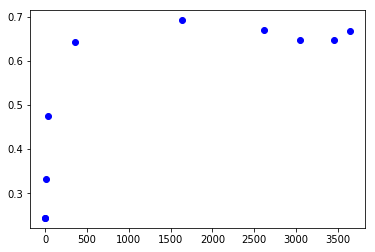

In [443]:
def P6(train_data, train_targets, test_data, test_targets):
    # Keep this random seed here to make comparison easier.
    np.random.seed(0)

    #setting the dictionary and the vector of features for each dataset:
    vectorizer = CountVectorizer()
    vector_train = vectorizer.fit_transform(train_data)
    vector_test = vectorizer.transform(test_data)
    
    #fitting the model for l1 regularization
    modLR5 = LogisticRegression(penalty='l1')
    modLR5 = modLR5.fit(vector_train, train_targets)
    predictedLR5 = modLR5.predict(vector_test)
    f1_resultLR5 = metrics.f1_score(test_targets, predictedLR5, average='macro')
    print 'L1 Penalty. Total count: {0}. Non-zero weight count: {1}. F1-Score: {2}.'.format(modLR5.coef_.size,np.count_nonzero(modLR5.coef_),f1_resultLR5)
    
    #fitting a new model for l2 regularization.
    modLR6 = LogisticRegression(penalty='l2')
    modLR6 = modLR6.fit(vector_train, train_targets)
    predictedLR6 = modLR6.predict(vector_test)
    f1_resultLR6 = metrics.f1_score(test_targets, predictedLR6, average='macro')
    print 'L2 Penalty. Total count: {0}. Non-zero weight count: {1}. F1-Score: {2}.'.format(modLR6.coef_.size,np.count_nonzero(modLR6.coef_), f1_resultLR6)
    
    # retrieving the non-zero elements from modLR5. If the word's column coeficient is in the columns array, means that
    # at least it whos in one of the labels as a non-zero weight.
    new_words_coefs = np.nonzero(modLR5.coef_)[1]
    new_dict = []
    
    for i in new_words_coefs:
        new_dict.append(vectorizer.get_feature_names()[i])
        
    new_dict = np.unique(new_dict) #removing possible duplicates
    
    #creating a new feature space with the new vocabulary
    vectorizer = CountVectorizer(vocabulary=new_dict)
    vector_train = vectorizer.transform(train_data)
    vector_test = vectorizer.transform(test_data)
    
    modLR7 = LogisticRegression(penalty='l2')
    modLR7 = modLR7.fit(vector_train, train_targets)
    predictedLR7 = modLR7.predict(vector_test)
    f1_resultLR7 = metrics.f1_score(test_targets, predictedLR7, average='macro')
    print 'L2 Penalty with new vocab. Total count: {0}. Non-zero weight count: {1}. F1-Score: {2}.'.format(modLR7.coef_.size,np.count_nonzero(modLR7.coef_),f1_resultLR7)
    
    #creating C values array and the outputs
    c_values = [10**k for k in range(-5,5)]
    vocab_sizes = []
    accuracies = []
    
    #Training models to get the outputs
    for c in c_values:
        modLR8 = LogisticRegression(C=c, penalty='l1')
        modLR8 = modLR8.fit(vector_train, train_targets)
        predictedLR8 = modLR8.predict(vector_test)
        f1_resultLR8 = metrics.f1_score(test_targets, predictedLR8, average='macro')
        accuracies.append(metrics.accuracy_score(test_targets, predictedLR8))
        vocab_sizes.append(np.count_nonzero(modLR8.coef_))
        
    #plot results:
    plt.plot(vocab_sizes, accuracies, 'bo')
        
P6(train_data, train_labels, dev_data, dev_labels)

**ANSWER:** We see that with L1 we keep 1609 words only, which stands for approx. 1.5% of the initial vocabulary. However we see that we may loose some efficiency of the algorithm with that method. Additionally, we see that the best accuracy were reached with C=10^0 = 1.

(7) Use the TfidfVectorizer -- how is this different from the CountVectorizer? Train a logistic regression model with C=100.

Make predictions on the dev data and show the top 3 documents where the ratio R is largest, where R is:

maximum predicted probability / predicted probability of the correct label

What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.

[4 pts]

In [508]:
def P7(train_data, train_targets, test_data, test_targets):

    #setting the dictionary and the vector of features for each dataset:
    vectorizer = TfidfVectorizer()
    vector_train = vectorizer.fit_transform(train_data)
    vector_test = vectorizer.transform(test_data)
    
    #fitting the model
    modLR9 = LogisticRegression(C=100)
    modLR9 = modLR9.fit(vector_train, train_targets)
    predictedLR9 = modLR9.predict(vector_test)
    outputs = modLR9.predict_proba(vector_test)
    f1_resultLR9 = metrics.f1_score(test_targets, predictedLR9, average='macro')
    print 'Total count: {0}. Non-zero weight count: {1}. F1-Score: {2}.'.format(modLR9.coef_.size,np.count_nonzero(modLR9.coef_),f1_resultLR9)
    
    #look for the highest ratio:
    ratio = []
    columns = ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']
    for i, prob in enumerate(outputs):
        #print prob, np.amax(prob), prob[test_targets[i]]
        ratio.append(np.amax(prob)/prob[test_targets[i]])
    
    ratio = np.array(ratio)
    top3 = np.argsort(ratio)[-3:] #441, 279, 475
    
    #print ratio[441], outputs[441], np.argmax(outputs[441]), test_targets[441], modLR9.predict(vector_test[441]), test_data[441]
    
    print(top3, outputs[279], test_targets.shape)
    for index, word in enumerate(top3):
        print '\nDocument number {0}'.format(word)
        print 'Predicted label:', columns[np.argmax(outputs[word])]
        print 'Correct label: ', columns[test_targets[word]]
        print 'Message:', test_data[word]
    
P7(train_data, train_labels, dev_data, dev_labels)

Total count: 107516. Non-zero weight count: 107516. F1-Score: 0.747391310165.
(array([607, 665, 215]), array([1.87486026e-01, 4.99237224e-05, 2.83401256e-05, 8.12435710e-01]), (676,))

Document number 607
Predicted label: talk.religion.misc
Correct label:  alt.atheism
Message: 
The 24 children were, of course, killed by a lone gunman in a second story
window, who fired eight bullets in the space of two seconds...


Document number 665
Predicted label: comp.graphics
Correct label:  talk.religion.misc
Message: Can anyone provide me a ftp site where I can obtain a online version
of the Book of Mormon. Please email the internet address if possible.

Document number 215
Predicted label: comp.graphics
Correct label:  talk.religion.misc
Message: I am pleased to announce that a *revised version* of _The Easy-to-Read Book
of Mormon_ (former title: _Mormon's Book_) by Lynn Matthews Anderson is now
available through anonymous ftp (see information below). In addition to the
change in title, the re

**ANSWER:** The TfIdfVectorizer use the **T**erm **F**requency `x` **I**nverse **D**ocument **F**requency methode, which essentially gives an extra weight in terms that are more rare in our dataset (the inverse of document frequency). This way, words that are particular from one label will have higher weight against words that are more frequent in all documents (like "the", "regards", etc).

In the end, we see that the documents that were classified incorrectly do have language that could belong to the other category. This kind of problem occurs because we are simply using the words that are in the document, not assigning any semantic meaing to the text.

One idea that could avoid the consfusion between the example number 665 would be cut words like online, email, ftp, etc from out dictionary, since that data comes from online forums and is expected that people talk about ways to send data back and forth using those tecnologies.


(8) EXTRA CREDIT

Try implementing one of your ideas based on your error analysis. Use logistic regression as your underlying model.

- [1 pt] for a reasonable attempt
- [2 pts] for improved performance